In [1]:
from __future__ import print_function
#import mrcnn
import json
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from io import BytesIO
from PIL import Image
import numpy as np
import matplotlib.patches as patches
#from mrcnn.visualize import random_colors, apply_mask, find_contours
import matplotlib.image as mpimg
from scipy.misc import toimage, imsave
from skimage import io
import glob
import skimage
from skimage import measure
from shapely.geometry import Polygon, MultiPolygon
import urllib.request
from shapely.affinity import scale
from skimage.color import grey2rgb
#import torch
import matplotlib.pylab as pylab
from maskrcnn_benchmark.structures.bounding_box import BoxList
pylab.rcParams['figure.figsize'] = 20, 12


In [2]:
ROOT = "/home/maxsen/git/master_thesis/data/"
DATA = "/home/maxsen/DEEPL/data/"

## Functions from matterport maskrcnn

In [3]:
# download images to chunk them
def download_img(anno_file, img_dir):
    
    anno = json.load(open(anno_file))
    for s in anno:
        name = s['External ID']
        url = s['Labeled Data']
        urllib.request.urlretrieve(url, img_dir + name)
        print('downloading %s'%(name))


In [4]:
# parse the json file with segmented info and link to the cloud storage
# with the images

def labelbox_annotations_parser(annotations_dir,annotation_file,img_size):
    
    """
    Remember that for labelbox:
    - origin (0,0) of the reference system in bottom left corner like
    cartesian system
    - labelbox can label objects outside the image so the coords
    need to be trimmed to the image size
    - This parser consider that all the images are square and same image size
    
    """
    
    annotations = json.load(open(annotations_dir+annotation_file))
    
    # Parse the annotation of the images done using labelbox.io
    # into a better formatted dict
    # Check with the company  where is the origin

    # create incremental number for all the identified objects
    obj_idx = 0

    print(annotations[0])
    # create a labels list
    labels_list = [] 
    labels_dict = {}

    # Reformatted dict
    annotations_dict = {}


    # Masks reference
    masks_urls_dict = {}

    # Loop through all the images
    # TODO: Check to skip non annotated images 
    for annotation_data in annotations:

        # Avoid error when empty images
        if isinstance(annotation_data['Label'],dict):
        # save the image id
            img_id = annotation_data['External ID']
            annotations_dict[img_id] = {}
            masks_urls_dict[img_id] = {}


            # create subdict with labels
            for lab in annotation_data['Label'].keys():
                if lab not in labels_list:
                    labels_list.append(lab) 
                annotations_dict[img_id][lab] = {}

            # Create labels dict with reference number starting from 1
            # because zero is for background
            lab_idx = 1
            for lab in labels_list:
                labels_dict[lab] = lab_idx
                lab_idx += 1

            # loop through the labels and convert the coords in a list of tuples
            for lab, objs in annotation_data['Label'].items():
                for obj_coords in objs:
                    coords = [tuple(coord_pair.values()) for coord_pair in obj_coords]
                
                    # Convert the coords in numpy array
                    coords = np.array(coords)
                    # labelbox reference system has (0,0) on the bottom left corner
                    # need to correct in order to have skimage system
                
                    # Flip cartesian y-axis
                    coords = np.abs(coords-np.array([0,img_size]))
                
                    # Swap x,y converting to [rr,cc] system
                    coords[:,[0,1]] = coords[:,[1,0]]
                
                    # Remove values that are ouside the range
                    #Remove points below 0
                    coords[coords<0] = 0
                
                    # Remove the point out of the upper limit of the edges
                    coords[coords>img_size] = img_size
                
                
                    annotations_dict[img_id][lab][obj_idx] = coords
                    obj_idx +=1

        
#        # Collect all the url for the masks
#        for lab in annotation_data['Masks'].keys():
#            masks_urls_dict[img_id][lab] = annotation_data['Masks'][lab]
            
    return annotations_dict, masks_urls_dict, labels_dict

# chunking
def chunking_labeled_images(number_chunks_dimension,class_names, img_raw,chunked_dir,annotations_dict):


    # Get image ids from annotations
    image_ids = list(annotations_dict.keys())

    for image_id in image_ids:

        # Define the image path
        image_path = img_raw + image_id

        # segmented regions
        polygons = annotations_dict[image_id]


        # Determine the size of the image
        image = skimage.io.imread(image_path)
        
        plt.imshow(image)
        plt.show()
        
        # Convert the image to uint8
        image = skimage.util.img_as_ubyte(image)
        # image = skimage.color.grey2rgb(image)
        height, width = image.shape[:2]

        # Load and create masks array

        # Determine how many objects of the different classes have been segmented
        instance_count = 0
        for lab in polygons:
            instance_count += len(list(polygons[lab].values()))

        mask = np.zeros([height, width, instance_count],
                        dtype=np.uint8)

        class_ids = []
        mask_layer = 0
        for lab, pgs in polygons.items():
            
            # Get the class id
            class_id = class_names.index(lab)

            for obj_num, coords in pgs.items():
                
                rr, cc = skimage.draw.polygon(coords[:,0], coords[:,1])
                mask[rr, cc, mask_layer] = class_id
                mask_layer += 1
                class_ids.append(class_id)


        class_ids = np.array(class_ids)

        # account for colored images
        if image.shape[2]:
            print('ss')
            dstack = np.dsplit(image,3)
            stack1 = dstack[0][:, :, 0]
            stack2 = dstack[1][:, :, 0]
            stack3 = dstack[2][:, :, 0]
            image_mask = np.insert(mask, 0, stack1, axis=2)
            image_mask = np.insert(image_mask, 0, stack2, axis=2)
            image_mask = np.insert(image_mask, 0, stack3, axis=2)
        else:
            image_mask = np.insert(mask,0,image,axis=2)
        
        print(image_mask.shape)
        sstack = np.dsplit(image_mask, image_mask.shape[2])
        plt.imshow(np.dstack((sstack[2], sstack[1], sstack[0])))
        plt.show()
        
        # stack image with masks

        # consider that we are collecting square images and only even number of cuts
        hsplits = np.split(image_mask,number_chunks_dimension,axis=0)
        total_images = []
        for split in hsplits:
                total_images.append(np.split(split,number_chunks_dimension,axis=1))
        total_images = [img for cpl in total_images for img in cpl] 

        # Chunk the images and the segmented data
        for idx,image_chunk in enumerate(total_images):
            image_chunks_ids = []
            mask = image_chunk != 0
            planes_to_keep = np.flatnonzero((mask).sum(axis=(0,1)))
            # Make sure that the image has labeled objects
            if planes_to_keep.size:
                image_chunk_trimmed = image_chunk[:,:,planes_to_keep]
                image_chunk_trimmed_id = image_id.split('.')[0]+'chunk'+str(idx)

                np.save(chunked_dir + image_chunk_trimmed_id, image_chunk_trimmed)


In [5]:
ROOT = "/home/max/github/master_thesis/data/"
DATA = "/data/proj/smFISH/Students/Max_Senftleben/files/data/"
#DATA = "/home/maxsen/DEEPL/data/training_data/"

raw_images = DATA + '20190306_poly_t/raw/'
#raw_images = DATA + 'raw/raw_nuclei/'

anno_dir = '/home/max/github/ms2/data/annotations/'
print(os.listdir(anno_dir))

start_annotation_file = 'export-2019-03-11T16_23_23.975Z_coco.json'
#start_annotation_file = 'All_labels_20181107.json'

# download images
#download_img(anno_dir + start_annotation_file, raw_images)

# transform image names to coco format
#trans(raw_images, anno_dir + start_annotation_file)


# parse annotation file
img_size = 1024


annotations_dict, masks_urls_dict, labels_dict = labelbox_annotations_parser(anno_dir, 
                                                                             start_annotation_file, 
                                                                             img_size)
# Number of chunks to create
# 2x2 or 4x4 etc.....
# it must be even
number_chunks_dimension = 2
class_names = ['BG']
_ = [class_names.append(i) for i in labels_dict]
print(class_names)

'''
# use this if using personal pc
#ROOT = "/home/maxsen/git/master_thesis/data/"
#DATA = "/home/maxsen/DEEPL/data/"

# dir to save the chunks
chunks_to_save_dir = DATA + '20190306_poly_t/npy/'
#chunks_to_save_dir = DATA + 'nuclei_20181107_data/what_npy/'

# run chunking

for s in os.listdir(raw_images):
    img = Image.open(raw_images + s)
    print(img)
    plt.imshow(img)
    plt.show()

chunking_labeled_images(number_chunks_dimension,
                        class_names, raw_images,
                        chunks_to_save_dir,
                        annotations_dict)
'''

['All_labels_20181107.json', 'instances_val2017.json', 'new_nuclei', 'nuclei_20181107', 'nuclei_20190205_with_masks.json', 'testing_only_coco.json', 'testing_only_nuclei_380.json', '20190304_raw_nuclei', '20190304_all_nuclei_large', 'PolyT-SV_export-2019-02-22T17_39_08.674Z.json', 'PolyT-SV_export-2019-02-22T17_39_08.674Z_coco.json', 'Guidelines for solitary work.doc', 'export-2019-03-11T16_23_23.975Z.json', 'export-2019-03-11T16_23_23.975Z_coco.json']
{'ID': 'cjfwcaf9dbjsh0162o78pz4sy', 'DataRow ID': 'cjftvrudqn0s4019228pjximp', 'Labeled Data': "https://firebasestorage.googleapis.com/v0/b/labelbox-193903.appspot.com/o/cjftcvd3thwdi0114gmseghlz%2F2d947498-3525-48a3-92b6-30002b28ddcf%2F%5B'BE87'%5Dcomp.png?alt=media&token=d17920fd-e7fa-4cdf-8bd3-06c66322be02", 'Label': {'Cell': [[{'x': 301, 'y': 457}, {'x': 289, 'y': 459}, {'x': 280, 'y': 460}, {'x': 273, 'y': 454}, {'x': 270, 'y': 440}, {'x': 280, 'y': 427}, {'x': 288, 'y': 424}, {'x': 296, 'y': 429}, {'x': 306, 'y': 441}], [{'x': 336,

'\n# use this if using personal pc\n#ROOT = "/home/maxsen/git/master_thesis/data/"\n#DATA = "/home/maxsen/DEEPL/data/"\n\n# dir to save the chunks\nchunks_to_save_dir = DATA + \'20190306_poly_t/npy/\'\n#chunks_to_save_dir = DATA + \'nuclei_20181107_data/what_npy/\'\n\n# run chunking\n\nfor s in os.listdir(raw_images):\n    img = Image.open(raw_images + s)\n    print(img)\n    plt.imshow(img)\n    plt.show()\n\nchunking_labeled_images(number_chunks_dimension,\n                        class_names, raw_images,\n                        chunks_to_save_dir,\n                        annotations_dict)\n'

## Functions own

In [6]:
# make sub mask
def make_sub_masks(np_array):

    
    sub_masks = {}
    
    width, height, dim = np_array.shape
    
    # go through the np.array pixel-wise
    for x in range(width):
        for y in range(height):
            
            # Get the pixel values from the numpy array
            a = np_array[y,x,0]
            b = np_array[y,x,1]
            c = np_array[y,x,2]
            # get pixel in RGB format
            pixel = (a,b,c)
            
            # if pixel is not background/black
            if pixel != (0,0,0):
                pixel_str = str(pixel)
                sub_mask = sub_masks.get(pixel_str)
                
                if sub_mask is None:
                    
                    # Create a sub-mask (one bit per pixel) and add to the dictionary
                    # Note: we add 1 pixel of padding in each direction
                    # because the contours module doesn't handle cases
                    # where pixels bleed to the edge of the image
                    
                    sub_masks[pixel_str] = Image.new('1', (width+2, height+2))

                # Set the pixel value to 1 (default is 0), accounting for padding
                sub_masks[pixel_str].putpixel((x+1, y+1), 1)
    
    return sub_masks

In [7]:
# make annotation for mask
def create_sub_mask_annotation(sub_mask, image_id, category_id, annotation_id, is_crowd = 0):
    
    # Find contours (boundary lines) around each sub-mask
    # Note: there could be multiple contours if the object
    # is partially occluded. (E.g. an elephant behind a tree)
    contours = measure.find_contours(sub_mask, 0.5, positive_orientation = "low")
    
    segmentations = []
    polygons = []
    
    for contour in contours:
        # Flip from (row, col) representation to (x, y)
        # and subtract the padding pixel
        for i in range(len(contour)):
            row, col = contour[i]
            contour[i] = (col - 1, row - 1)

        # Make Polygon and simplify it
        
        #contour = contour.dot([[-1,0],[0,-1]])
        #contour = abs(contour)
        poly = Polygon(contour)
        
        poly = poly.simplify(1.0, preserve_topology = False)
        
        # transform IMPORTANT
        
        
        polygons.append(poly)
        
        #print("contour: ", contour)
        #print("poly.wkt: ", poly.wkt)
        
        segmentation = np.array(poly.exterior.coords).ravel().tolist()
        segmentations.append(segmentation)
        
    # combine polygons to calculate the bounding box and area
    multi_poly = MultiPolygon(polygons)
    x, y, max_x, max_y = multi_poly.bounds
    width = max_x - x
    height = max_y - y
    bbox = (x, y, width, height)
    area = multi_poly.area

    # write everything in coco-annotation-
    # like format
    annotation = {
        'segmentation': segmentations,
        'iscrowd': is_crowd,
        'image_id': int(image_id),
        'category_id': int(category_id),
        'id': int(annotation_id),
        'bbox': bbox,
        'area': area
    }
    
    return annotation

In [8]:
def combine_masks_boxes(np_array, filename, width, height, dim, images_to_save_folder, annotation_id, is_crowd = 0):
        
        chunk_id = str(filename[-len("00.npy"):-len(".npy")])

        # depending on dataset used        
        if filename.startswith('Nuclei_SN'):
            img_id = str(filename[len("Nuclei_SN_Hyb2_pos_"):-len("chunk00.npy")])
            image_id = (img_id + chunk_id)
            filename = filename[0:len("Nuclei_SN_Hyb2_pos_")] + str(image_id) + ".png"
        
        elif filename.startswith('Raw_Nuclei'):
            img_id = str(filename[len("Raw_Nuclei_"):-len("chunk00.npy")])
            image_id = (img_id + chunk_id)
            filename = filename[0:len("Raw_Nuclei_")] + str(image_id) + ".png"
        
        elif filename.startswith('B'):
            img_id = str(filename[len("BE87_"):-len("chunk00.npy")])
            image_id = (img_id + chunk_id)
            filename = filename[0:len("BE87_")] + str(image_id) + ".png"
            
        # full image_id, i.e. 150 see above
        array_split = np.split(np_array, dim, axis=2)
        
        # images without segmentations have shape (1024, 1024, 1)
        # updated filename with correct image_id
        
        annotations = []
        
        
        # account for non-empty annotation
        if True:
            image = {
                'id' : int(image_id),
                'width' : width,
                'height' : height,
                'file_name' : filename,
                'license' : None,
                'flickr_url' : None,
                'coco_url' : None,
                'date_captured' : None
            }
            
            #images.append(image)
            
            # save ground truth
            print(len(array_split))
            ground_truth = np.dstack((array_split[2],array_split[1], array_split[0]))
            plt.imshow(ground_truth)
            plt.show()
            #ground_truth = grey2rgb(np.squeeze(array_split[0], axis = 2))
            im = Image.fromarray(ground_truth)
            im.save(images_to_save_folder + filename)
            
            # change to 3 if colored
            for i in range(3, len(array_split)):
                try:
                    stacked_array = np.dstack((array_split[i], array_split[i], array_split[i]))
                    sub_masks = make_sub_masks(stacked_array)
                
                    for color, sub_mask in sub_masks.items():
                        cat_id = category_ids[color]
                        #print(cat_id)
                        annotation = create_sub_mask_annotation(sub_mask, image_id, cat_id, annotation_id, is_crowd)
                        annotations.append(annotation)
                        #print(annotation_id)
                        annotation_id += 1
                except AttributeError:
                    print("Attribute Error was raised, check shape of file")
            return image, annotations, annotation_id
            
            

In [9]:
# combine both scripts above
def combine(categories, info, licenses, 
            category_ids, annotation_file, 
            chunks_dir,
            images_to_save_folder,
            is_crowd = 0, limit = None, AUGMENT = False):
    
    # set annotations and images
    annotations = []
    images = []
    annotation_id = 1
    
    # go through folder of chunks in .npy format
    # i.e. Nuclei_SN_Hyb2_pos_15chunk0.npy
    # IMPORTANT
    # the image_id will be 150, 15 for the image number
    # and 0 for the first chunk of the whole image
    # this is because the image_id has to be integer
    # chunks were created like this:  0 1
    #                                 2 3

    # option to limit
    x = 0
    
    for one_file in os.listdir(chunks_dir):
        if limit:
            if x <= limit:
                print('pass')
                pass
            else:
                print('continue')
                continue
                

        print("File {} is processed".format(one_file))
        filename = one_file
        print(filename[:-4] + '0.npy')
        
        # load numpy file
        #print(chunks_dir + one_file)
        np_array = np.load(chunks_dir + one_file)
        height, width, dim = np_array.shape
        
        # do augmentation
        if AUGMENT and dim > 2:    # numpy.rot90(m, k=1, axes=(0, 1))
            
            # offline augmentation
            np_array1 = np.rot90(np_array, k=1, axes=(0, 1))
            np_array2 = np.rot90(np_array, k=2, axes=(0, 1))
            np_array3 = np.rot90(np_array, k=3, axes=(0, 1))
            np_array4 = np.flip(np_array, axis=0)
            np_array5 = np.flip(np_array1, axis=0)
            np_array6 = np.flip(np_array2, axis=0)
            np_array7 = np.flip(np_array3, axis=0)    
            
            image, annos, anno_id = combine_masks_boxes(np_array, filename[:-4] + '0.npy', width, height, dim, images_to_save_folder, annotation_id, is_crowd)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array1, filename[:-4] + '1.npy', width, height, dim, images_to_save_folder, annotation_id, is_crowd)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array2, filename[:-4] + '2.npy', width, height, dim, images_to_save_folder, annotation_id, is_crowd)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array3, filename[:-4] + '3.npy', width, height, dim, images_to_save_folder, annotation_id, is_crowd)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array4, filename[:-4] + '4.npy', width, height, dim, images_to_save_folder, annotation_id, is_crowd)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array5, filename[:-4] + '5.npy', width, height, dim, images_to_save_folder, annotation_id, is_crowd)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array6, filename[:-4] + '6.npy', width, height, dim, images_to_save_folder, annotation_id, is_crowd)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            image, annos, anno_id = combine_masks_boxes(np_array7, filename[:-4] + '7.npy', width, height, dim, images_to_save_folder, annotation_id, is_crowd)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            x += 1
            
        elif AUGMENT == False and dim > 2:
            image, annos, anno_id = combine_masks_boxes(np_array, filename, width, height, dim, images_to_save_folder, annotation_id)
            annotation_id = anno_id
            images.append(image)
            annotations.append(annos)
            print("Masks and Annotations obtained")
            x += 1
        else:
            print('No annos')
        
    # save all annotations to json file
    print("write annotation to: ", annotation_file)
    with open(annotation_file, "w") as write_file:
        json.dump(
                {"info":info,
                 "annotations":[item for sublist in annotations for item in sublist], 
                 "images":images,
                 "licenses":licenses,
                 "categories":categories}, write_file)

## Transform image names to numbers so one can convert to COCO-format

In [10]:
def trans(image_folder, anno_file):
    files = os.listdir(image_folder)
    anno = json.load(open(anno_file))
    dict_trans = {name: name[2:6] + '_' + str(i) for i, name in enumerate(files, 40)}
    [print(i, dict_trans[i]) for i in dict_trans]
    for name in dict_trans:
        new = dict_trans[name] + '.png'
        os.rename(image_folder + name, image_folder + new)
    for i, s in enumerate(anno):
        if s['External ID'] in dict_trans:
            anno[i]['External ID'] = dict_trans[anno[i]['External ID']] + '.png'
    with open(anno_file[:-5] + '_coco.json', 'w') as w:
        json.dump(anno, w)
    # print conversion dictionary
    

## Set variables and paths

### can be optimized much more, just a preliminary solution

In [11]:
# 1 is for nuclei, 2 is for undefined and 3 is for cluster
category_ids = {
                '(1, 1, 1)':1,
                '(2, 2, 2)':3,
                '(3, 3, 3)':2,
                '(4, 4, 4)':4
               }

# pass categories in coco json file
'''
categories = [{'supercategory': 'nuclei', 'id': 1, 'name': 'nuclei'}, 
              {'supercategory': 'undefined', 'id': 2, 'name': 'undefined'}, 
              {'supercategory': 'clusters', 'id': 3, 'name': 'clusters'}]
'''
categories = [
    {'supercategory': 'Cell', 'id': 1, 'name': 'Nclei'}, 
    {'supercategory': 'Undefined', 'id': 3, 'name': 'Undefined'}, 
    {'supercategory': 'Clusters', 'id': 2, 'name': 'Clusters'},
    {'supercategory': 'Junk', 'id': 4, 'name': 'Junk'}
]

# pass licenses
licenses = []



# pass info
info = {'year': 2018, 
        'version': None, 
        'description': 'RNA staining segmentation SV', 
        'contributor': 'katharina.koetter@stud.ki.se', 
        'url': 'labelbox.com', 
        'date_created': '2018-04-12T09:46:52.000Z'
       }

#ROOT = "/home/maxsen/git/master_thesis/data/"
#DATA = "/home/maxsen/DEEPL/data/"

# dir of chunks in .npy format
#CHUNKS = DATA + 'training_data/large_data_extracted_396chunks_2+2/'
CHUNKS1 = '/data/proj/smFISH/Students/Max_Senftleben/files/data/20190306_poly_t/train_npy/'
CHUNKS2 = '/data/proj/smFISH/Students/Max_Senftleben/files/data/20190306_poly_t/val_npy/'
CHUNKS = '/data/proj/smFISH/Students/Max_Senftleben/files/data/20190306_poly_t/npy/'

# chunked images to save
NEW_CHUNK_DIR1 = '/data/proj/smFISH/Students/Max_Senftleben/files/data/20190306_poly_t/train/'
NEW_CHUNK_DIR2 = '/data/proj/smFISH/Students/Max_Senftleben/files/data/20190306_poly_t/val/'
NEW_CHUNK_DIR = '/data/proj/smFISH/Students/Max_Senftleben/files/data/20190306_poly_t/npy_test/'

# define annotation file
anno_file1 = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190306_poly_t/train_poly_t.json'
anno_file2 = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190306_poly_t/val_poly_t.json'
anno_file = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190306_poly_t/testssss.json'

File BR83_57chunk2.npy is processed
BR83_57chunk20.npy
43


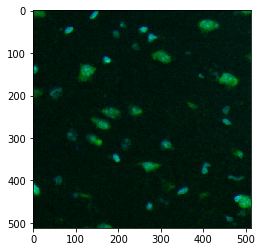

43


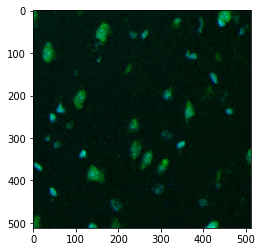

43


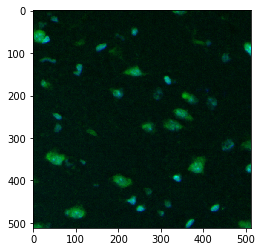

43


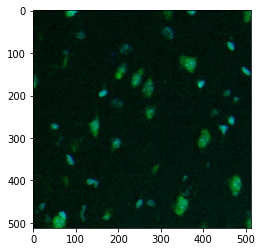

43


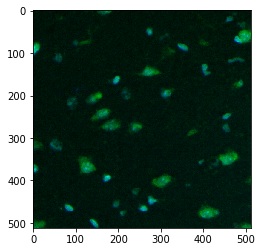

43


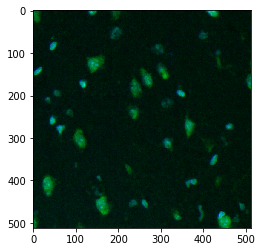

43


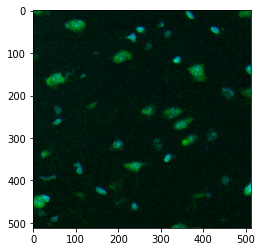

43


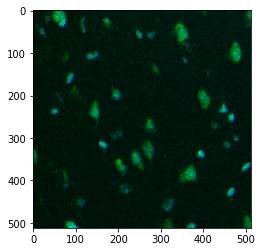

File BR83_57chunk3.npy is processed
BR83_57chunk30.npy
60


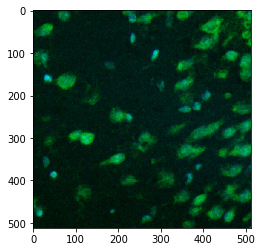

Attribute Error was raised, check shape of file
60


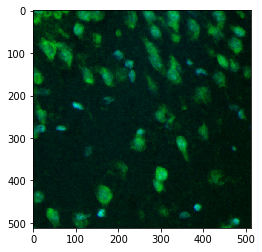

Attribute Error was raised, check shape of file
60


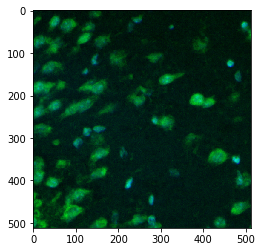

Attribute Error was raised, check shape of file
60


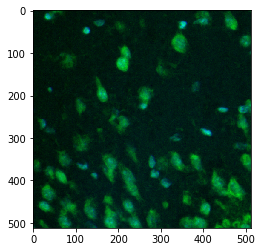

Attribute Error was raised, check shape of file
60


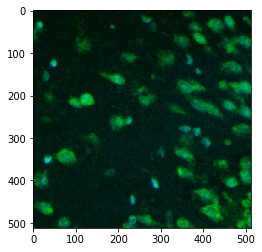

Attribute Error was raised, check shape of file
60


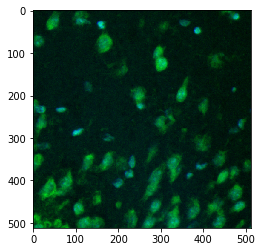

Attribute Error was raised, check shape of file
60


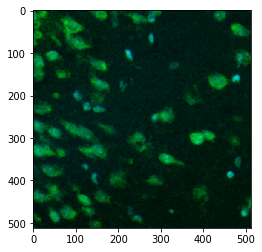

Attribute Error was raised, check shape of file
60


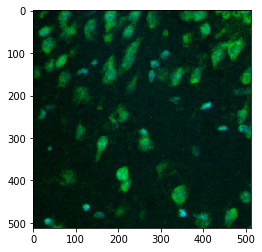

Attribute Error was raised, check shape of file
File BT88_49chunk0.npy is processed
BT88_49chunk00.npy
66


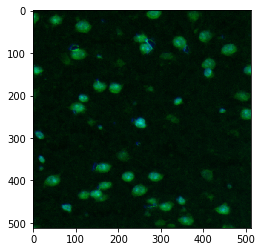

Attribute Error was raised, check shape of file
66


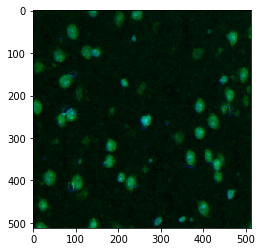

Attribute Error was raised, check shape of file
66


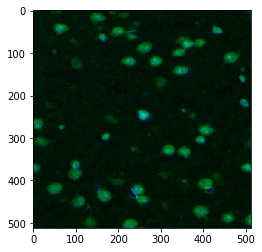

Attribute Error was raised, check shape of file
66


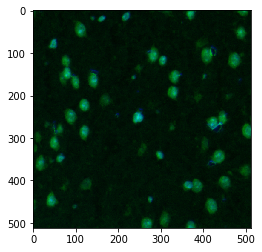

Attribute Error was raised, check shape of file
66


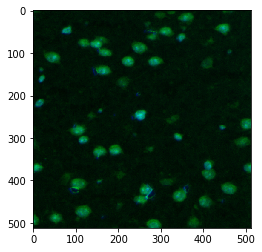

Attribute Error was raised, check shape of file
66


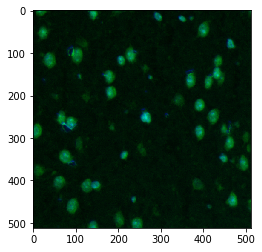

Attribute Error was raised, check shape of file
66


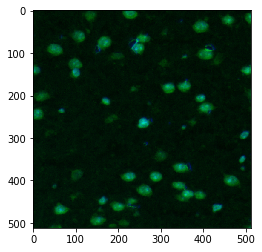

Attribute Error was raised, check shape of file
66


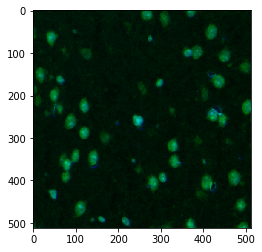

Attribute Error was raised, check shape of file
File BT88_49chunk1.npy is processed
BT88_49chunk10.npy
62


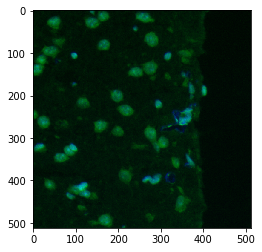

62


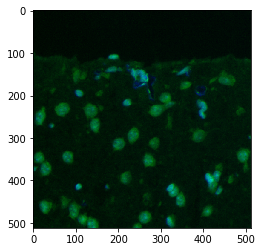

62


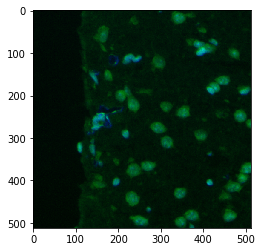

62


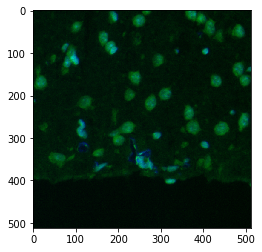

62


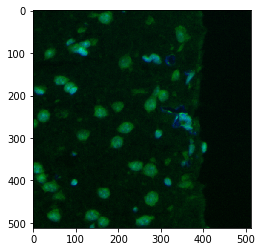

62


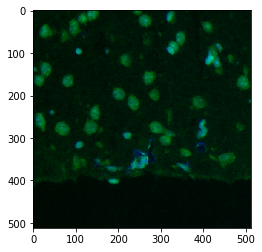

62


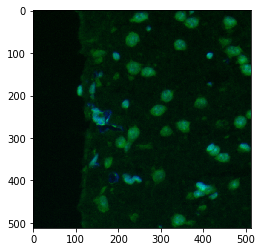

62


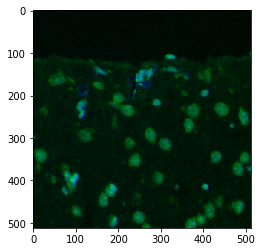

File BT88_49chunk2.npy is processed
BT88_49chunk20.npy
58


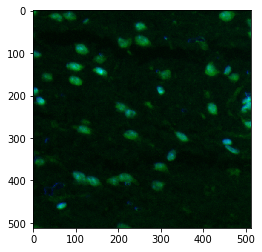

58


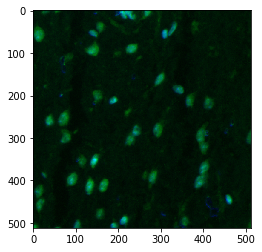

58


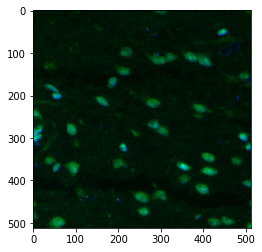

58


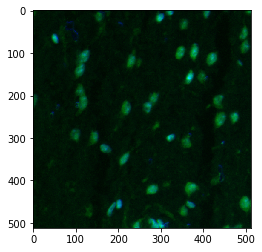

58


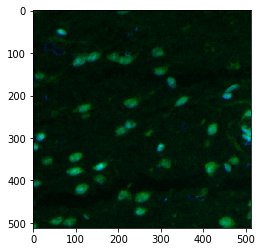

58


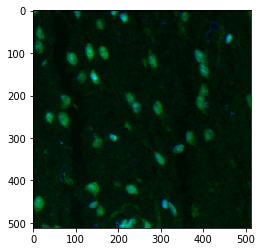

58


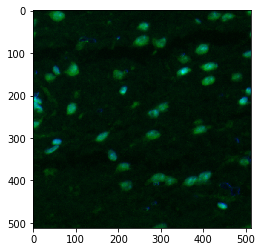

58


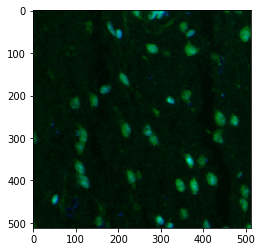

File BT88_49chunk3.npy is processed
BT88_49chunk30.npy
40


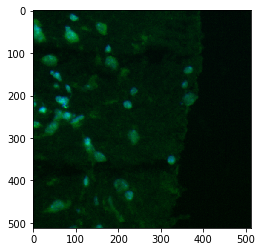

40


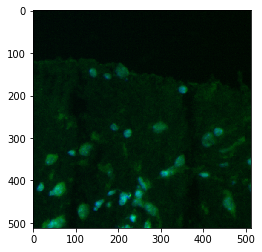

40


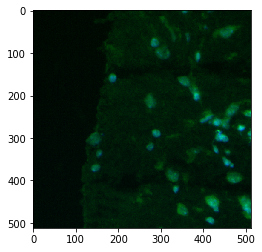

40


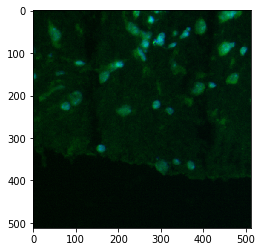

40


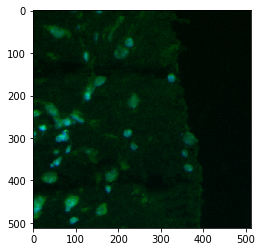

40


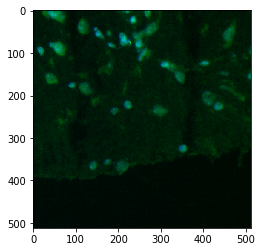

40


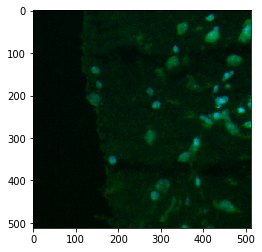

40


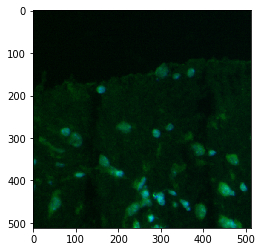

File BU90_58chunk0.npy is processed
BU90_58chunk00.npy
32


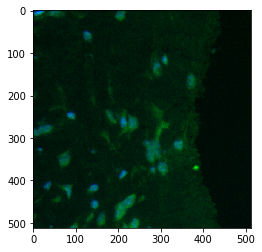

32


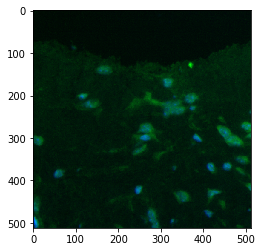

32


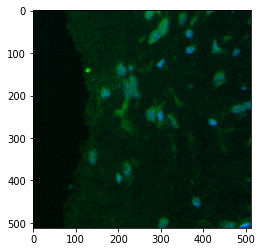

32


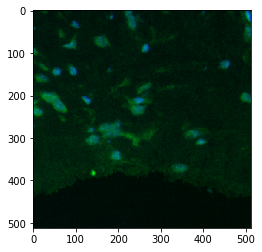

32


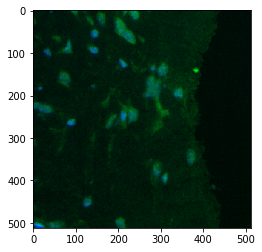

32


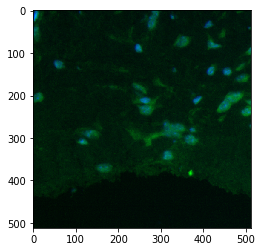

32


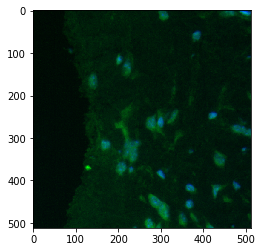

32


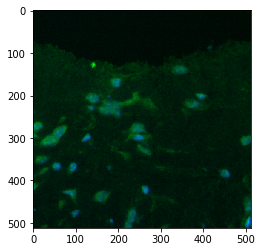

File BU90_58chunk1.npy is processed
BU90_58chunk10.npy
No annos
File BU90_58chunk2.npy is processed
BU90_58chunk20.npy
23


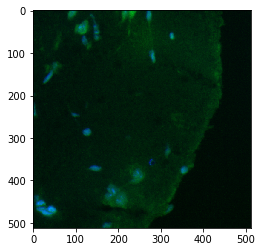

23


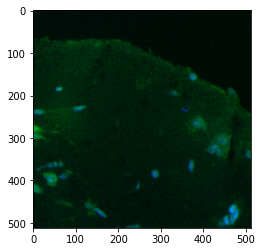

23


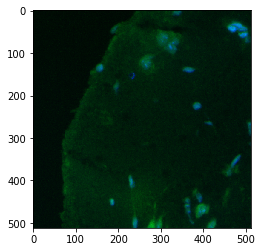

23


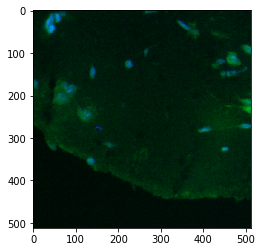

23


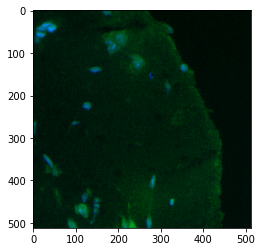

23


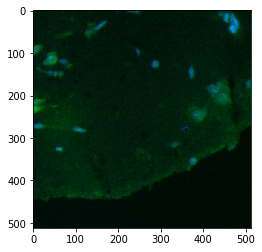

23


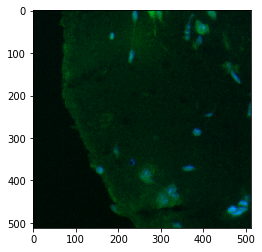

23


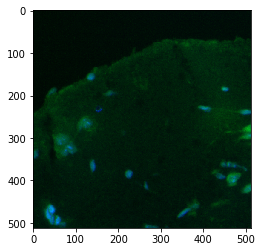

File BU90_58chunk3.npy is processed
BU90_58chunk30.npy
No annos
write annotation to:  /data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190306_poly_t/val_poly_t.json
val done


'\ncombine(categories, info, licenses, \n        category_ids, anno_file2, \n        CHUNKS2, NEW_CHUNK_DIR2, AUGMENT = True)\n\n'

In [12]:
# set the categories, ingo, licenses, 
# category_ids referring to the RGB-color-coded sub-classes,
# annotation file, 
# directory of chunks to be processed,
# directory of images to be saved


combine(categories, info, licenses, 
        category_ids, anno_file2, 
        CHUNKS2, NEW_CHUNK_DIR2, AUGMENT = True)
print('val done')
'''
combine(categories, info, licenses, 
        category_ids, anno_file2, 
        CHUNKS2, NEW_CHUNK_DIR2, AUGMENT = True)

'''

In [24]:
###### check chunks
# increasing the size of figures
pylab.rcParams['figure.figsize'] = 20, 12

anno = anno_file1
img_dir = NEW_CHUNK_DIR1
import cv2

'''coco_id = 1163

from pycocotools.coco import COCO
coco = COCO(anno_file)
'''
from maskrcnn_benchmark.structures.segmentation_mask import SegmentationMask
from matplotlib.patches import Rectangle
from pycocotools.coco import *

data = json.load(open(anno))
coco = COCO(anno) ; x = 0
for i,image in enumerate(data['images']):
    if x >= 0:
        pass
    else:
        continue
    x += 1
    print(image['file_name'], i)
    
    img = Image.open(img_dir + image['file_name'])
    anno = [obj for obj in data['annotations'] if obj['image_id'] == image['id']]
    boxes = [obj['bbox'] for obj in anno]
    boxes = torch.as_tensor(boxes).reshape(-1,4)
    target = BoxList(boxes, img.size, mode = 'xywh').convert('xyxy')
    
    classes = [obj['category_id'] for obj in data['annotations'] if obj['image_id'] == image['id']]
    json_category_id_to_contiguous_id = {
            v: i + 1 for i, v in enumerate(coco.getCatIds())
    }
    classes = [json_category_id_to_contiguous_id[c] for c in classes]
    classes = torch.tensor(classes)

    target.add_field('labels', classes)

    masks = [obj["segmentation"] for obj in anno]
    masks = SegmentationMask(masks, img.size)
    target.add_field("masks", masks)

    target = target.clip_to_image(remove_empty=True)
    
    plt.imshow(img); plt.axis('off')
    ax = plt.gca()
    
    polygons = []
    color = []
    boxes = []
    
    polys = vars(target)['extra_fields']['masks']
    for polygon in polys:
        try:
            tenso = vars(polygon)['polygons'][0]
        except KeyError:
            continue
        c = (np.random.random((1, 3))*0.6+0.4).tolist()[0]
        poly1 = tenso.numpy()
        poly = poly1.reshape((int(len(poly1)/2),2))
        polygons.append(Polygon(poly))
        color.append(c)

    xywh_tar = target.convert("xywh")
    for box in vars(xywh_tar)['bbox'].numpy():

        rect = Rectangle((box[0],box[1]), box[2], box[3])
        boxes.append(rect)
        
    b = PatchCollection(boxes, facecolor = 'none', linewidths = 1, edgecolor = color)
    p = PatchCollection(polygons, facecolor = 'none', linewidths = 0, alpha = 0.4)
    ax.add_collection(p)
    ax.add_collection(b)
    p = PatchCollection(polygons, facecolor = 'none', edgecolors = color, linewidths = 2)
    ax.add_collection(p)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190306_poly_t/train_poly_t.json'

In [ ]:
# pop keys from files which are not 
# that great refer to log



def pop_image_from_anno(anno_old, anno_new, list_to_pop):
    data = json.load(open(anno_old))
    to_write_imgs = [i for i in data['images'] if i['id'] not in list_to_pop]
    to_write_anno = [i for i in data['annotations'] if i['image_id'] not in list_to_pop]
    for x, i in enumerate(to_write_imgs):
        #print(i)
        if i['id'] == 533:
            to_write_imgs[x]['id'] = 534
            to_write_imgs[x]['file_name'] = 'Nuclei_SN_Hyb2_pos_534.png'
            
    for x, i in enumerate(to_write_anno):
        if i['image_id'] == 533:
            to_write_anno[x]['image_id'] = 534
            
    
    with open(anno_new, 'w') as write:
        json.dump(
                {"info":data['info'],
                 "annotations":to_write_anno, 
                 "images":to_write_imgs,
                 "licenses":data['licenses'],
                 "categories":data['categories']}, write)
list_1 = [1203, 1241, 1242, 1273, 1341, 1363, 1410, 1411, 1412, 1531, 1532, 1533, 152, 160, 162, 1861, 1883, 2120, 2122, 2150, 2172, 2180, 2181, 40]
list_2 = [291, 311, 312, 332, 372]
list_aug = []
for i in list_2:
    for s in range(8):
        c = int(str(i) + str(s))
        list_aug.append(c)
print(list_aug)
list_3 = [453, 503, 592, 600, 620, 712, 452, 500, 502, 503, 512, 552, 563, 600, 732, 761]

anno_file = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190309_aug_pop/val_nuclei.json'
pop_image_from_anno(anno_file, anno_file + '_pop.json', list_aug)

In [ ]:
# combine annotation files
def combine(anno_1, anno_2, anno_comb):
    data1 = json.load(open(anno_1))
    data2 = json.load(open(anno_2))
    img = sum([data1['images'], data2['images']], [])
    annos = sum([data1['annotations'], data2['annotations']], [])
    
    with open(anno_comb, 'w') as write:
        json.dump(
                {"info":data1['info'],
                 "annotations":annos, 
                 "images":img,
                 "licenses":data1['licenses'],
                 "categories":data1['categories']}, write)
    

In [ ]:
anno_file1 = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190304_all_nuclei_large/train_nuclei_pop.json'
anno_file2 = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190304_all_nuclei_large/tval_nuclei_pop.json'
anno_file3 = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190304_all_nuclei_large/test_nuclei_pop.json'

anno_1 = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190304_raw_nuclei/train_nuclei.json'
anno_2 = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190304_raw_nuclei/val_nuclei.json'
anno_3 = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190304_raw_nuclei/test_nuclei.json'

new_anno = '/data/proj/smFISH/Students/Max_Senftleben/files/annotation/20190306_all_and_raw/'

combine(anno_file3, anno_3, new_anno + 'test_comb.json')

In [13]:
data = json.load(open(new_anno + 'val_comb.json'))
print(len([i['id'] for i in data['images']]))
print(len(set([i['id'] for i in data['images']])))

NameError: name 'new_anno' is not defined